In [1]:
%cd /root/capsule/code
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pipeline import foraging_model, lab, experiment, foraging_analysis_and_export, foraging_analysis
from pipeline.plot import foraging_model_plot, foraging_plot
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pipeline.model import descriptive_analysis
from pipeline.export import to_s3

/root/capsule/code


[2023-02-25 05:36:31,412][INFO]: Connecting map-superuser@datajoint.mesoscale-activity-map.org:3306
[2023-02-25 05:36:31,971][INFO]: Connected map-superuser@datajoint.mesoscale-activity-map.org:3306


### RT analysis

In [46]:
subject = (lab.WaterRestriction & 'water_restriction_number="XY_10"').fetch1('KEY')
sess_key= {**subject, 'session': 33}
key = sess_key

In [12]:
if_photostim = len((experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"'))) > 10

c, r, iti, p, q = foraging_model.get_session_history(sess_key, remove_ignored=True)
reaction_time = (foraging_analysis.TrialStats & q).fetch('reaction_time', order_by='trial').astype(float)
trial_non_ignore = q.fetch('trial', order_by='trial')

trial_valid_start, trial_valid_end = (foraging_analysis.SessionEngagementControl & key).fetch1('start_trial', 'end_trial')

idx_valid_in_non_ignore = (trial_valid_start <= trial_non_ignore) & (trial_non_ignore <= trial_valid_end)
choice = c[0][idx_valid_in_non_ignore]
reward = np.sum(r, axis=0)[idx_valid_in_non_ignore]
iti = iti[idx_valid_in_non_ignore]
reaction_time = reaction_time[idx_valid_in_non_ignore]

if if_photostim:
    trial_photostim_and_non_ignore = (experiment.PhotostimForagingTrial & q).fetch('trial', order_by='trial')
    trial_non_ignore_and_valid = trial_non_ignore[idx_valid_in_non_ignore]
    idx_photostim_in_non_ignore_and_valid = np.nonzero(np.in1d(trial_non_ignore_and_valid, trial_photostim_and_non_ignore))[0]   # np.searchsorted(non_ignore_trial, photostim_trial)
else:
    idx_photostim_in_non_ignore_and_valid = None

<AxesSubplot: >

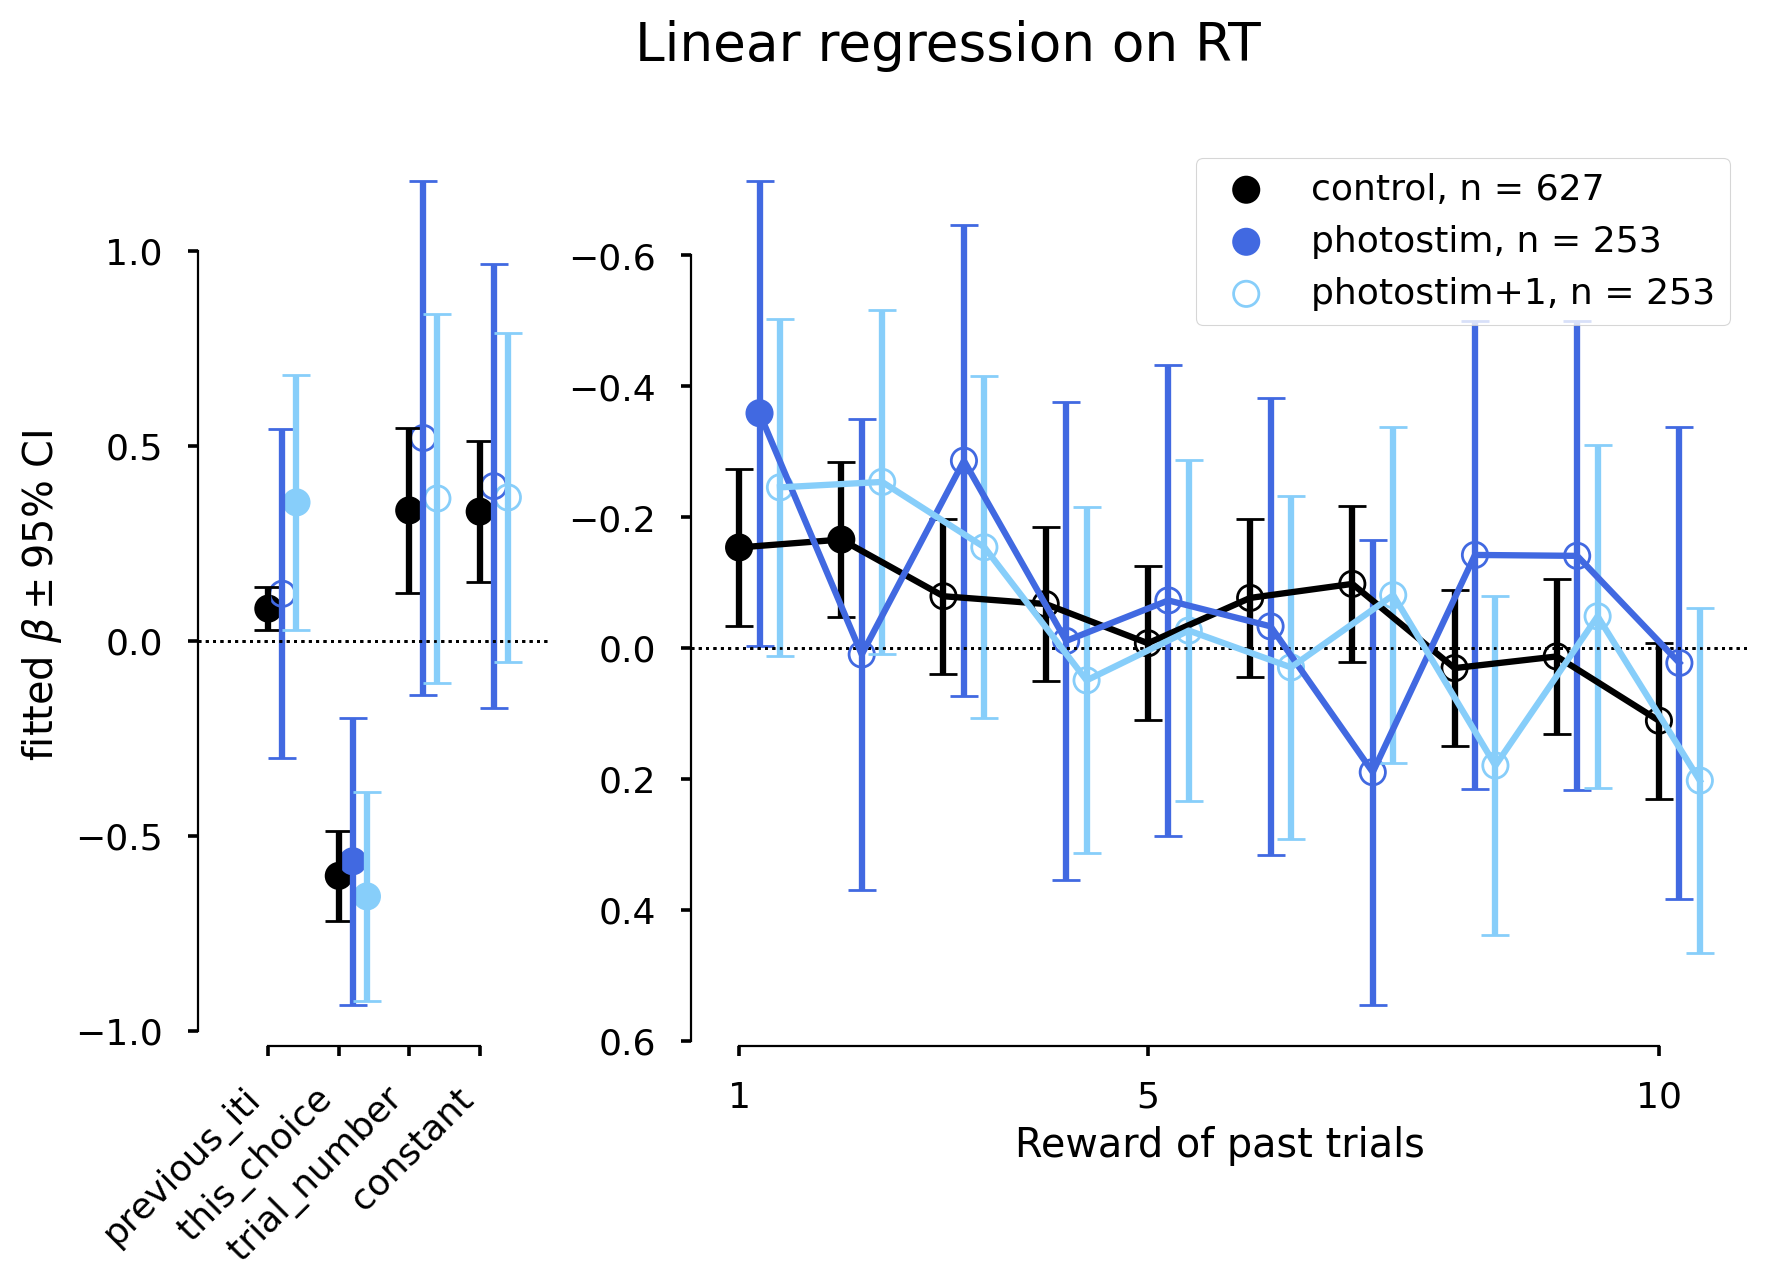

In [65]:
photostim_idx = idx_photostim_in_non_ignore_and_valid

ctrl_idx = np.setdiff1d(np.arange(len(choice)), photostim_idx)

# Fit models for control, photostim, photostim_next
data_ctrl, Y_ctrl, x_name = descriptive_analysis.prepare_linear_reg_RT(choice, reward, reaction_time, iti,
                                                                       selected_trial_idx=ctrl_idx)
linear_reg = descriptive_analysis.linear_regression(data_ctrl, Y_ctrl, x_name)
# descriptive_analysis.plot_linear_regression_RT(linear_reg)

data_photostim0, Y_photostim0, _ = descriptive_analysis.prepare_linear_reg_RT(choice, reward, reaction_time, iti,
                                                                       selected_trial_idx=photostim_idx)
linear_reg_photostim0 = descriptive_analysis.linear_regression(data_photostim0, Y_photostim0, x_name)


data_photostim1, Y_photostim1, _ = descriptive_analysis.prepare_linear_reg_RT(choice, reward, reaction_time, iti,
                                                                       selected_trial_idx=photostim_idx + 1)
linear_reg_photostim1 = descriptive_analysis.linear_regression(data_photostim1, Y_photostim1, x_name)

descriptive_analysis.plot_linear_regression_RT([linear_reg, linear_reg_photostim, linear_reg_photostim1])
 

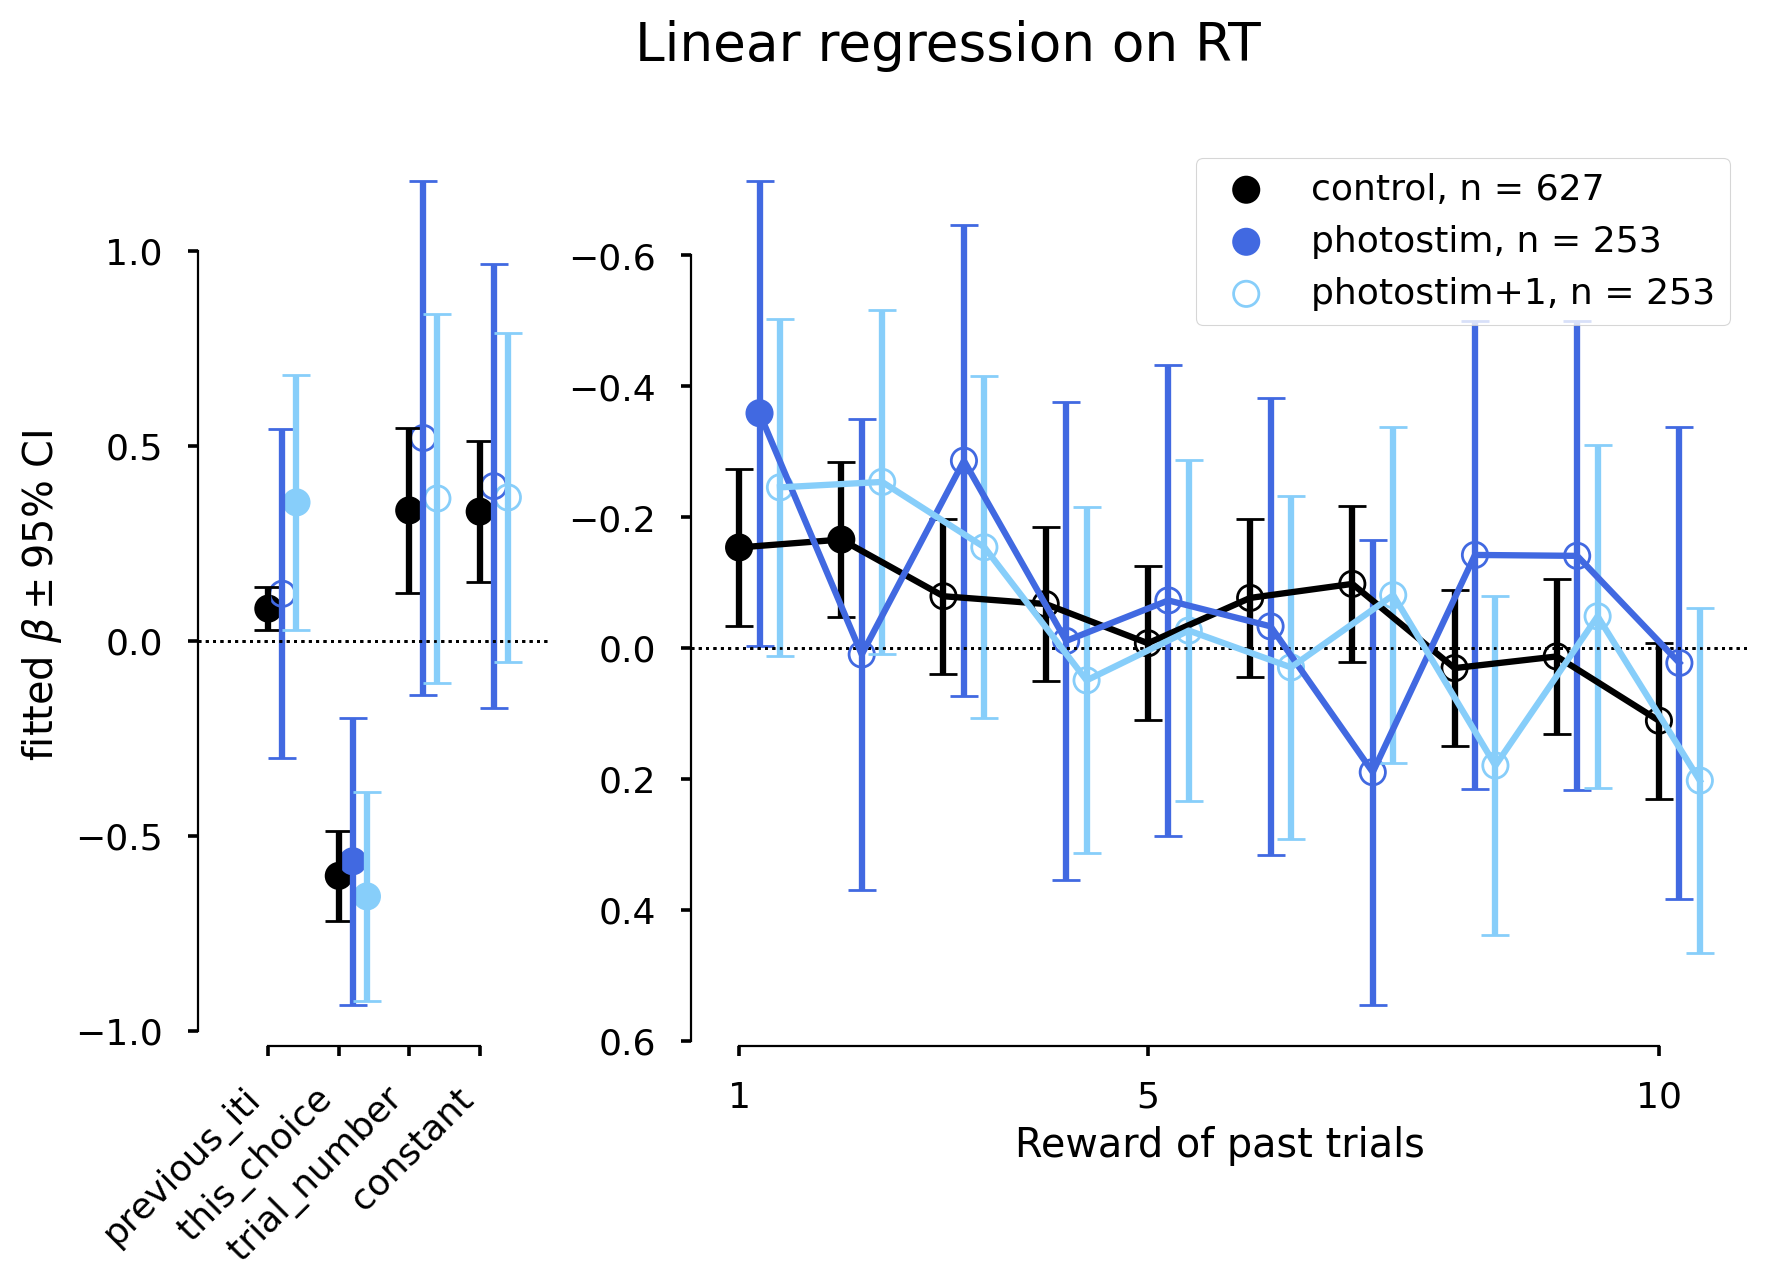

In [69]:
descriptive_analysis.plot_session_linear_reg_RT(choice, reward, reaction_time, iti,
                                                photostim_idx=idx_photostim_in_non_ignore_and_valid)

In [44]:
foraging_analysis_and_export.SessionLinearRegressionRT.delete_all()

[2023-02-25 06:27:45,123][INFO]: Deleting 10192 rows from `map_v2_foraging_analysis_and_export`.`__session_linear_regression_r_t__param`
[2023-02-25 06:27:45,633][INFO]: Deleting 698 rows from `map_v2_foraging_analysis_and_export`.`__session_linear_regression_r_t`


Deletes committed.


In [28]:
from pipeline.export import to_s3
to_s3.export_df_regressions()
to_s3.export_df_foraging_sessions()

file exported to Han/ephys/report/st_cache/df_linear_regression_rt.pkl, size = 2.861064910888672 MB, df_length = 41552
file exported to Han/ephys/report/st_cache/df_logistic_regression.pkl, size = 6.148446083068848 MB, df_length = 95728
file exported to Han/ephys/report/st_cache/df_sessions.pkl, size = 0.8232488632202148 MB, df_length = 2869


,subject_id,session,session_date,h2o,finished,foraging_eff,photostim,task,ephys_ins,histology,...,mean_reward_sum,mean_reward_contrast,reward_rate,miss_rate,ignore_rate,block_length,not_pretrain,valid_trial_start,valid_trial_end,valid_ratio
0,447921,38,2019-11-01,HC16,384,0.9571,,coupled_block_baiting,0,,...,0.450,5.61306,0.2897,0.5365,0.1738,51.7778,1.0,1,453,0.972103
1,447921,37,2019-10-31,HC16,270,0.8898,,coupled_block_baiting,0,,...,0.450,5.18258,0.2842,0.4424,0.2735,53.2857,1.0,1,346,0.927614
2,447921,36,2019-10-30,HC16,799,0.8933,,coupled_block_baiting,0,,...,0.450,5.61280,0.3552,0.6133,0.0315,43.4211,1.0,7,825,0.992727
3,447921,35,2019-10-29,HC16,566,0.6404,,coupled_block_baiting,0,,...,0.450,6.25251,0.2316,0.6729,0.0955,71.0000,1.0,1,638,0.998435
4,447921,34,2019-10-28,HC16,710,0.8007,,coupled_block_baiting,0,,...,0.450,5.87316,0.3160,0.6307,0.0533,53.5714,1.0,1,750,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,661100,5,2023-02-13,XY_21,459,0.7692,,coupled_block_baiting,0,,...,0.922,4.53340,0.5328,0.4440,0.0233,3.1959,1.0,1,454,0.959831
2865,661100,4,2023-02-10,XY_21,402,0.7928,,coupled_block_baiting,0,,...,1.000,4.00000,0.6511,0.3391,0.0098,50.8750,1.0,2,407,0.997543
2866,661100,3,2023-02-09,XY_21,427,0.6800,,coupled_block_baiting,0,,...,0.450,4.68897,0.2951,0.6433,0.0616,42.8182,1.0,15,471,0.970276
2867,661100,2,2023-02-08,XY_21,375,0.5935,,coupled_block_baiting,0,,...,0.800,7.00347,0.3881,0.4840,0.1279,24.6842,1.0,7,469,0.987207


In [27]:
foraging_analysis_and_export.SessionLogisticRegression & 'trials_back <= 10'

subject_id institution 6 digit animal ID,session session number,"trial_group no_stim_all, ctrl, photostim, photostim_next, photostim_next5","beta RewC, UnrC, C, bias",trials_back,mean,lower_ci,upper_ci
447921,1,all_no_stim,bias,0,-0.0713296,-0.0939623,-0.0446238
447921,1,all_no_stim,C,1,0.0657621,0.0382804,0.0909837
447921,1,all_no_stim,C,2,0.0550263,0.0284034,0.0819159
447921,1,all_no_stim,C,3,0.0428426,0.0161323,0.0704899
447921,1,all_no_stim,C,4,0.0181586,-0.00855309,0.0438674
447921,1,all_no_stim,C,5,0.0164525,-0.00901634,0.0433871
447921,1,all_no_stim,C,6,0.00368422,-0.0238147,0.0304465
447921,1,all_no_stim,C,7,0.00106114,-0.025007,0.0262754
447921,1,all_no_stim,C,8,0.012045,-0.0145943,0.0375203
447921,1,all_no_stim,C,9,0.0197747,-0.00616544,0.0473285


In [13]:
foraging_analysis_and_export.SessionLinearRegressionRT.delete_all()

[autoreload of pipeline.foraging_analysis_and_export failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.8/site-packag

Deletes committed.


In [8]:
foraging_analysis_and_export.SessionLinearRegressionRT.progress()

SessionLinearRegressionRT Completed 95 of 101 (94.1%)   2023-02-25 05:33:35


(6, 101)

In [8]:
(foraging_analysis.TrialStats * experiment.WaterPortChoice * experiment.Session).heading

subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
trial                : smallint                     # trial number (1-based indexing)
---
reaction_time=null   : decimal(8,4)                 # reaction time in seconds (first lick relative to go cue) [-1 in case of ignore trials]
double_dipping=null  : tinyint                      # Whether this is a double dipped trial
water_port=null      : varchar(16)                  # e.g. left, right, middle, top-left, purple
session_date         : date                         # 
session_time         : time                         # 
username             : varchar(24)                  # 
rig                  : varchar(24)                  # 

In [171]:
if_photostim = len((experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"'))) > 10

In [153]:
X, Y, x_name = descriptive_analysis.prepare_linear_reg_RT(choice, reward, 
                                                          reaction_time, iti,
                                                          trials_back=10)
reg = descriptive_analysis.linear_regression(X, Y, x_name)

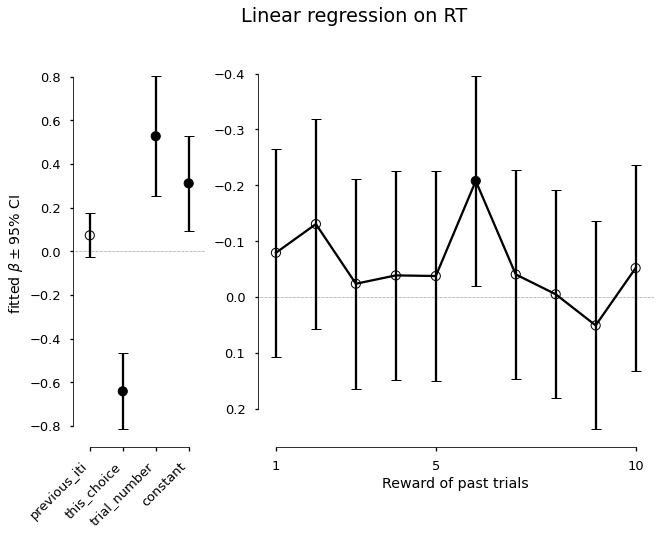

In [159]:
from pipeline.model.descriptive_analysis import plot_linear_regression_RT
plot_linear_regression_RT(reg);

In [ ]:

def plot_session_linear_reg_RT(choice, reward, reaction_time, iti, photostim_idx=None, n_samplesize=None, ax=None):
'''
Generate plots for linear regression on RT
If there are photostimulation trials, plot ctrl, photostim, and photostim + 1 separately
'''

if photostim_idx is None:
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Logistic regression on all trials
    data, Y, x_name = descriptive_analysis.prepare_linear_reg_RT(choice, reward, reaction_time, iti)
    linear_reg_RT = descriptive_analysis.linear_regression(data, Y)
    descriptive_analysis.plot_(linear_reg_RT, ax=ax)
    
    return [logistic_reg]

else:    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 20))

    # add subaxis in ax
    gs = ax._subplotspec.subgridspec(2, 2, height_ratios=[1, 3], width_ratios = [1, 1])
    ax_fit_ctrl = ax.get_figure().add_subplot(gs[0, 0])
    ax_fit_photostim = ax.get_figure().add_subplot(gs[0, 1])
    ax_compare = ax.get_figure().add_subplot(gs[1, :])
    
    ax_fit_photostim.get_shared_y_axes().join(ax_fit_photostim, ax_fit_ctrl)
    
    # Get control and photostim trials (non-ignored only)
    ctrl_idx = np.setdiff1d(np.arange(len(choice)), photostim_idx)
        
    # Fit models for control, photostim, photostim_next
    data_ctrl, Y_ctrl = descriptive_analysis.prepare_logistic(choice, reward, selected_trial_idx=ctrl_idx)
    logistic_reg_ctrl = descriptive_analysis.logistic_regression_bootstrap(data_ctrl, Y_ctrl, n_bootstrap=1000, n_samplesize=n_samplesize, Cs=20)
    descriptive_analysis.plot_logistic_regression(logistic_reg_ctrl, ax_fit_ctrl)
    ax_fit_ctrl.get_legend().remove()
    ax_fit_ctrl.set(title=ax_fit_ctrl.get_title() + f'\ncontrol trials (n={len(ctrl_idx)})')

    data_photostim, Y_photostim = descriptive_analysis.prepare_logistic(choice, reward, selected_trial_idx=photostim_idx)
    logistic_reg_photostim = descriptive_analysis.logistic_regression_bootstrap(data_photostim, Y_photostim, n_bootstrap=1000, n_samplesize=n_samplesize, Cs=20)
    descriptive_analysis.plot_logistic_regression(logistic_reg_photostim, ax_fit_photostim)
    ax_fit_photostim.set(title=ax_fit_photostim.get_title() + f'\nphotostim trials (n={len(photostim_idx)}, {len(photostim_idx) / len(choice):.2%})')
    ax_fit_photostim.set(yticks=[], ylabel='')
  
    data_photostim_next5, Y_photostim_next5 = descriptive_analysis.prepare_logistic(choice, reward, selected_trial_idx=photostim_idx + 5)
    logistic_reg_photostim_next5 = descriptive_analysis.logistic_regression_bootstrap(data_photostim_next5, Y_photostim_next5, n_bootstrap=1000, n_samplesize=n_samplesize, Cs=20)
    
    descriptive_analysis.plot_logistic_compare([logistic_reg_ctrl, logistic_reg_photostim, logistic_reg_photostim_next, logistic_reg_photostim_next5], 
                                                labels=['ctrl', 'photostim', 'photostim_next', 'photostim_5_later'], 
                                                edgecolors=['None', 'deepskyblue', 'skyblue', 'skyblue'],
                                                ax_all=ax_compare)

    ax.remove()

    return [logistic_reg_ctrl, logistic_reg_photostim, logistic_reg_photostim_next, logistic_reg_photostim_next5]    


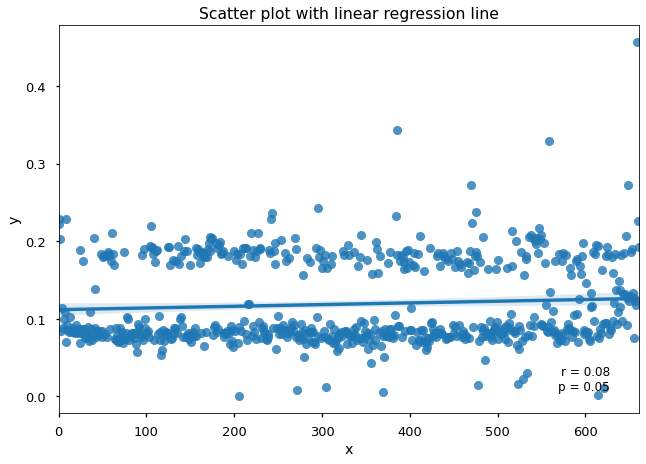

In [165]:
import seaborn as sns
import scipy

x = np.arange(len(reaction_time))
y = reaction_time

# create a scatter plot with linear regression line
sns.regplot(x=x, y=y)

# set the title and axis labels
plt.title("Scatter plot with linear regression line")
plt.xlabel("x")
plt.ylabel("y")

# add correlation coefficient and p-value to the plot
r, p = scipy.stats.pearsonr(x, y)
textstr = f"r = {r:.2f}\np = {p:.2f}"
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# show the plot
plt.show()


In [ ]:
import seaborn as sns
sns.rel

In [ ]:
from pipeline.foraging_model_plot import plot_session_linear_reg_RT


In [ ]:
        
        if_photostim = len((experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"'))) > 10
        
        if not if_photostim:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            trial_groups = ['all_no_stim']
        else:
            fig, ax = plt.subplots(1, 1, figsize=(10, 20))
            trial_groups = ['ctrl', 'photostim', 'photostim_next', 'photostim_next5']
        
        # Do linear regression and generate figures
        
        c, r, iti, p, q = foraging_model.get_session_history(sess_key, remove_ignored=True)
        reaction_time = (foraging_analysis.TrialStats & sess_key).fetch('reaction_time').astype(float)
        reaction_time = reaction_time[~np.isnan(reaction_time)]

        start_trial, end_trial = (foraging_analysis.SessionEngagementControl & sess_key).fetch1('start_trial', 'end_trial')
        valid_trial_idx = (start_trial <= q.fetch('trial')) & (q.fetch('trial') <= end_trial)
        choice = c[0][valid_trial_idx]
        reward = np.sum(r, axis=0)[valid_trial_idx]
        iti = iti[valid_trial_idx]
        reaction_time = reaction_time[valid_trial_idx]
        
        if if_photostim:
            non_ignore_trial = (experiment.BehaviorTrial & key & 'outcome != "ignore"').fetch('trial')
            photostim_trial = (experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"')).fetch('trial')
            photostim_idx = np.nonzero(np.in1d(non_ignore_trial, photostim_trial))[0]   # np.searchsorted(non_ignore_trial, photostim_trial)
        else:
            photostim_idx = None
        
        logistic_regs = foraging_model_plot.plot_session_logistic(choice, reward, photostim_idx=photostim_idx, ax=ax)

In [53]:
{f'{name}': (p, value) for name, p, value in zip(reg.x_name, reg.pvalues, reg.params)}

{'constant': (7.135539290358289e-18, -0.9452003320066081),
 'previous_iti': (0.16972088745196318, 0.0320770723488285),
 'this_choice': (0.22829945352169181, 0.07880755512669688),
 'trial_number': (1.0589456538335776e-23, 0.0013561391186259365),
 'reward_-10': (0.4461836649157097, 0.058759586021636195),
 'reward_-9': (0.33481665192656196, 0.07500289086315262),
 'reward_-8': (0.08526291190502741, 0.13331971731593986),
 'reward_-7': (0.7818731680897821, -0.02146931700135509),
 'reward_-6': (0.09348431005473481, 0.1302443708308886),
 'reward_-5': (0.41982822437979117, 0.06277402694897569),
 'reward_-4': (0.2996231476791181, 0.08082711360616196),
 'reward_-3': (0.06396629282787958, 0.14366151648623293),
 'reward_-2': (0.5210406802009339, 0.04984788375113982),
 'reward_-1': (8.497722256160266e-05, 0.30466246429442345)}

In [63]:
import scipy
scipy.stats.pearsonr(reward[:-3], reaction_time[3:])

PearsonRResult(statistic=0.0874810102487393, pvalue=0.01018074957378981)

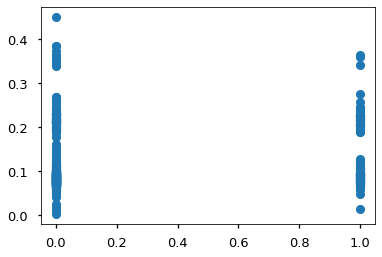

In [58]:
plt.plot(reward[:-1], reaction_time[1:], 'o')